# In this notebook I will load in the microglia single cell data from the Millet et. al. paper and integrate with my dataset.
I will use two different integration methods, label transfer and cca(?).
The Millet data was originally uploaded as a Seurat object. that was converted to h5ad. First thing is to open the h5ad and verify all data was kept. 

First load in some basic modules.


In [2]:
import sys
import os
import re

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import scanpy as sc
import anndata as ad

notebook_dir = os.path.abspath(os.path.join(os.getcwd(), '..'))
if notebook_dir not in sys.path:
    sys.path.append(notebook_dir)
import func_lib as f

In [3]:
print(os.getcwd())

/Users/loganlarlham/Documents/Summer_proj_2024/Notebooks/Analysis


In [4]:
Adata = sc.read_h5ad('/Users/loganlarlham/Documents/Summer_proj_2024/Notebooks/Analysis/Logan_adata.h5ad')
Adata_recomp = Adata.copy()
Adata

AnnData object with n_obs × n_vars = 27722 × 17341
    obs: 'Classification', 'most_likely_hypothesis', 'genotype', 'apoe', 'disease', 'treatment', 'genotype_treatment', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'n_counts', 'n_genes', 'sample', 'norm_total_counts', 'S_score', 'phase', 'cellcycle', 'anno2', 'umap_density_genotype_treatment'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection'
    uns: 'anno2_colors', 'apoe_colors', 'dendrogram_anno2', 'disease_colors', 'genotype_colors', 'genotype_treatment_colors', 'hvg', 'log1p', 'name', 'neighbors', 'pca', 'rank_genes_groups', 'sample_colors', 'treatment_colors', 'umap', 'umap_density_genotype_treatment_params'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'counts', 'log_norm'
    obsp: 'connectivities', 'distances'

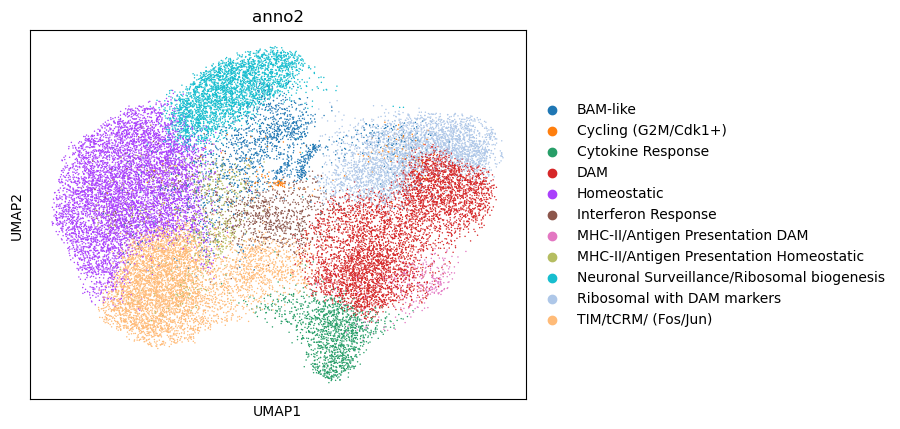

In [5]:
sc.pl.umap(Adata, color='anno2')

In [6]:
Madata = sc.read_h5ad('/Users/loganlarlham/Documents/Summer_proj_2024/Millet et al data/Millet_Seurat_GSE225503_mglia_only.h5ad')
Madata

/opt/homebrew/Caskroom/mambaforge/envs/Scanpy_env2_omni/lib/python3.12/site-packages/anndata/compat/__init__.py:363: FutureWarning: Moving element from .uns['neighbors']['distances'] to .obsp['distances'].

This is where adjacency matrices should go now.
  warn(


AnnData object with n_obs × n_vars = 24750 × 3000
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'nCount_HTO', 'nFeature_HTO', 'age', 'percent.mt', 'miQC.probability', 'miQC.keep', 'nCount_SCT', 'nFeature_SCT', 'integrated_snn_res.1.4', 'seurat_clusters', 'genotype', 'clust_id', 'microglia', 'SCT_snn_res.0.6', 'mglia_ident'
    var: 'features', 'integrated_features'
    uns: 'neighbors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'integrated'
    obsp: 'distances'

In [7]:
print(Madata.obs['genotype'].value_counts())
Madata.obs['genotype'] = Madata.obs['genotype'].astype('category')

print(Madata.obs['age'].value_counts())
Madata.obs['age'] = Madata.obs['age'].astype('category')

print(Madata.obs['orig.ident'].value_counts())

print(Madata.obs['mglia_ident'].value_counts())
Madata.obs['mglia_ident'] = Madata.obs['mglia_ident'].astype('category')

print(Madata.obs['seurat_clusters'].value_counts())
Madata.obs['seurat_clusters'] = Madata.obs['seurat_clusters'].astype('category')

genotype
1    11201
2     8327
0     5222
Name: count, dtype: int64
age
1    9628
0    7784
2    7338
Name: count, dtype: int64
orig.ident
6    5310
5    3965
4    3176
0    2735
1    2715
3    2487
2    2334
7    2028
Name: count, dtype: int64
mglia_ident
0     4139
15    3195
1     2720
7     2321
5     2197
12    1676
9     1615
14    1446
2     1090
4      752
8      704
13     553
10     498
16     375
3      353
18     286
17     270
6      221
19     179
20     149
11      11
Name: count, dtype: int64
seurat_clusters
0     4139
1     3195
2     2321
3     2197
4     1856
5     1676
6     1615
7     1446
8     1090
9      864
10     752
11     704
12     553
13     498
14     375
15     353
16     297
17     270
18     221
19     179
20     149
Name: count, dtype: int64


In [8]:
# age mapping
level_mapping = {0: "10wk", 1: "20wk", 2: "2yr"}
Madata.obs['age'] = Madata.obs['age'].map(level_mapping)
Madata.obs['age']

E2_10wk_AAACCTGAGCTCCTCT-1    10wk
E2_10wk_AAACCTGAGTTACCCA-1    10wk
E2_10wk_AAACCTGCAATAAGCA-1    10wk
E2_10wk_AAACCTGCAGCCACCA-1    10wk
E2_10wk_AAACCTGCAGGGATTG-1    10wk
                              ... 
E4_2yr_TTTGACTTCGATACGT-1      2yr
E4_2yr_TTTGATCCAATGAAAC-1      2yr
E4_2yr_TTTGGAGCAAACGAGC-1      2yr
E4_2yr_TTTGGTTAGTTTGCTG-1      2yr
E4_2yr_TTTGTTGTCCCGAAAT-1      2yr
Name: age, Length: 24750, dtype: category
Categories (3, object): ['10wk', '20wk', '2yr']

In [9]:
#Mask Madata to only include age 10wk and 20wk
Madata = Madata[Madata.obs['age'].isin(['10wk', '20wk'])]

In [10]:
Madata

View of AnnData object with n_obs × n_vars = 17412 × 3000
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'nCount_HTO', 'nFeature_HTO', 'age', 'percent.mt', 'miQC.probability', 'miQC.keep', 'nCount_SCT', 'nFeature_SCT', 'integrated_snn_res.1.4', 'seurat_clusters', 'genotype', 'clust_id', 'microglia', 'SCT_snn_res.0.6', 'mglia_ident'
    var: 'features', 'integrated_features'
    uns: 'neighbors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'integrated'
    obsp: 'distances'

In [11]:
# Define the mapping based on the R code snippet
mglia_ident_mapping = {
0:               "Homeostatic Microglia",
1:                    "Effector-lo TIMs",
2:   "Poised-like Homeostatic Microglia",
3:           "Hspa1+ Stressed Microglia",
4:     "Lars2-mid Homeostatic Microglia",
5:      "Ier2/5+ Inflammatory Microglia",
6:                               "DAM-2",
7:      "Ccl3/4+ Inflammatory Microglia",
8:      "Lars2-hi Homeostatic Microglia",
9:     "Lars2-mid Homeostatic Microglia",
10:       "Rgs1-hi Homeostatic Microglia",
11:                               "DAM-1",
12:     "Adamts1+ Inflammatory Microglia",
13:        "Interferon Induced Microglia",
14:                    "Effector-hi TIMs",
15: "Bri3-Negative Homeostatic Microglia",
16:   "MHCII+ Microglia, Il34+ Microglia",
17:                      "Serpine1+ TIMs",
18:           "Hspb1+ Stressed Microglia",
19:                     "Cd74+ Microglia",
20:                  "Cycling Microglia"
}

# Map 'mglia_ident' column to the new identities
Madata.obs['ident_name'] = Madata.obs['seurat_clusters'].map(mglia_ident_mapping)

# Define the type mapping
ident_type_mapping = {}

# Assign types based on the given index groups
for i in [15, 16, 17]:  # TIMs
    ident_type_mapping[i] = "TIMs"
for i in [0, 1, 2, 3, 4, 7]:  # Homeostatic
    ident_type_mapping[i] = "Homeostatic"
for i in [5,6]: # Stressed
    ident_type_mapping[i] = "Stressed"
for i in [8, 9]:  # DAMs
    ident_type_mapping[i] = "DAMs"
for i in [10, 11, 12, 13, 14]:  # Inflammatory
    ident_type_mapping[i] = "Inflammatory"

# Map the 'mglia_ident' column to the 'ident_type' column
Madata.obs['ident_type'] = Madata.obs['mglia_ident'].map(ident_type_mapping)

/var/folders/n8/l_thwp511tqdnvx3xvmjy3y80000gn/T/ipykernel_81091/1188751941.py:27: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  Madata.obs['ident_name'] = Madata.obs['seurat_clusters'].map(mglia_ident_mapping)


In [12]:
Madata.obs['ident_name'].value_counts()

ident_name
Homeostatic Microglia                  4108
Lars2-mid Homeostatic Microglia        2679
Poised-like Homeostatic Microglia      2296
Ier2/5+ Inflammatory Microglia         1341
Hspa1+ Stressed Microglia              1243
DAM-2                                  1208
Lars2-hi Homeostatic Microglia         1087
Rgs1-hi Homeostatic Microglia           684
DAM-1                                   670
Ccl3/4+ Inflammatory Microglia          576
Interferon Induced Microglia            426
Adamts1+ Inflammatory Microglia         345
Bri3-Negative Homeostatic Microglia     325
MHCII+ Microglia, Il34+ Microglia       192
Cycling Microglia                       112
Hspb1+ Stressed Microglia                89
Effector-lo TIMs                         19
Cd74+ Microglia                          12
Name: count, dtype: int64

In [13]:
Madata_recomp = Madata.copy()

sc.pp.pca(Madata_recomp)
sc.pp.neighbors(Madata_recomp)
sc.tl.umap(Madata_recomp)
Madata_recomp

AnnData object with n_obs × n_vars = 17412 × 3000
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'nCount_HTO', 'nFeature_HTO', 'age', 'percent.mt', 'miQC.probability', 'miQC.keep', 'nCount_SCT', 'nFeature_SCT', 'integrated_snn_res.1.4', 'seurat_clusters', 'genotype', 'clust_id', 'microglia', 'SCT_snn_res.0.6', 'mglia_ident', 'ident_name', 'ident_type'
    var: 'features', 'integrated_features'
    uns: 'neighbors', 'pca', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'integrated'
    obsp: 'distances', 'connectivities'

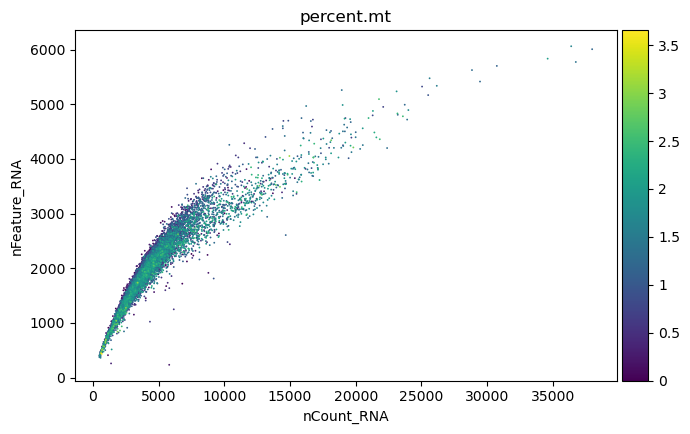

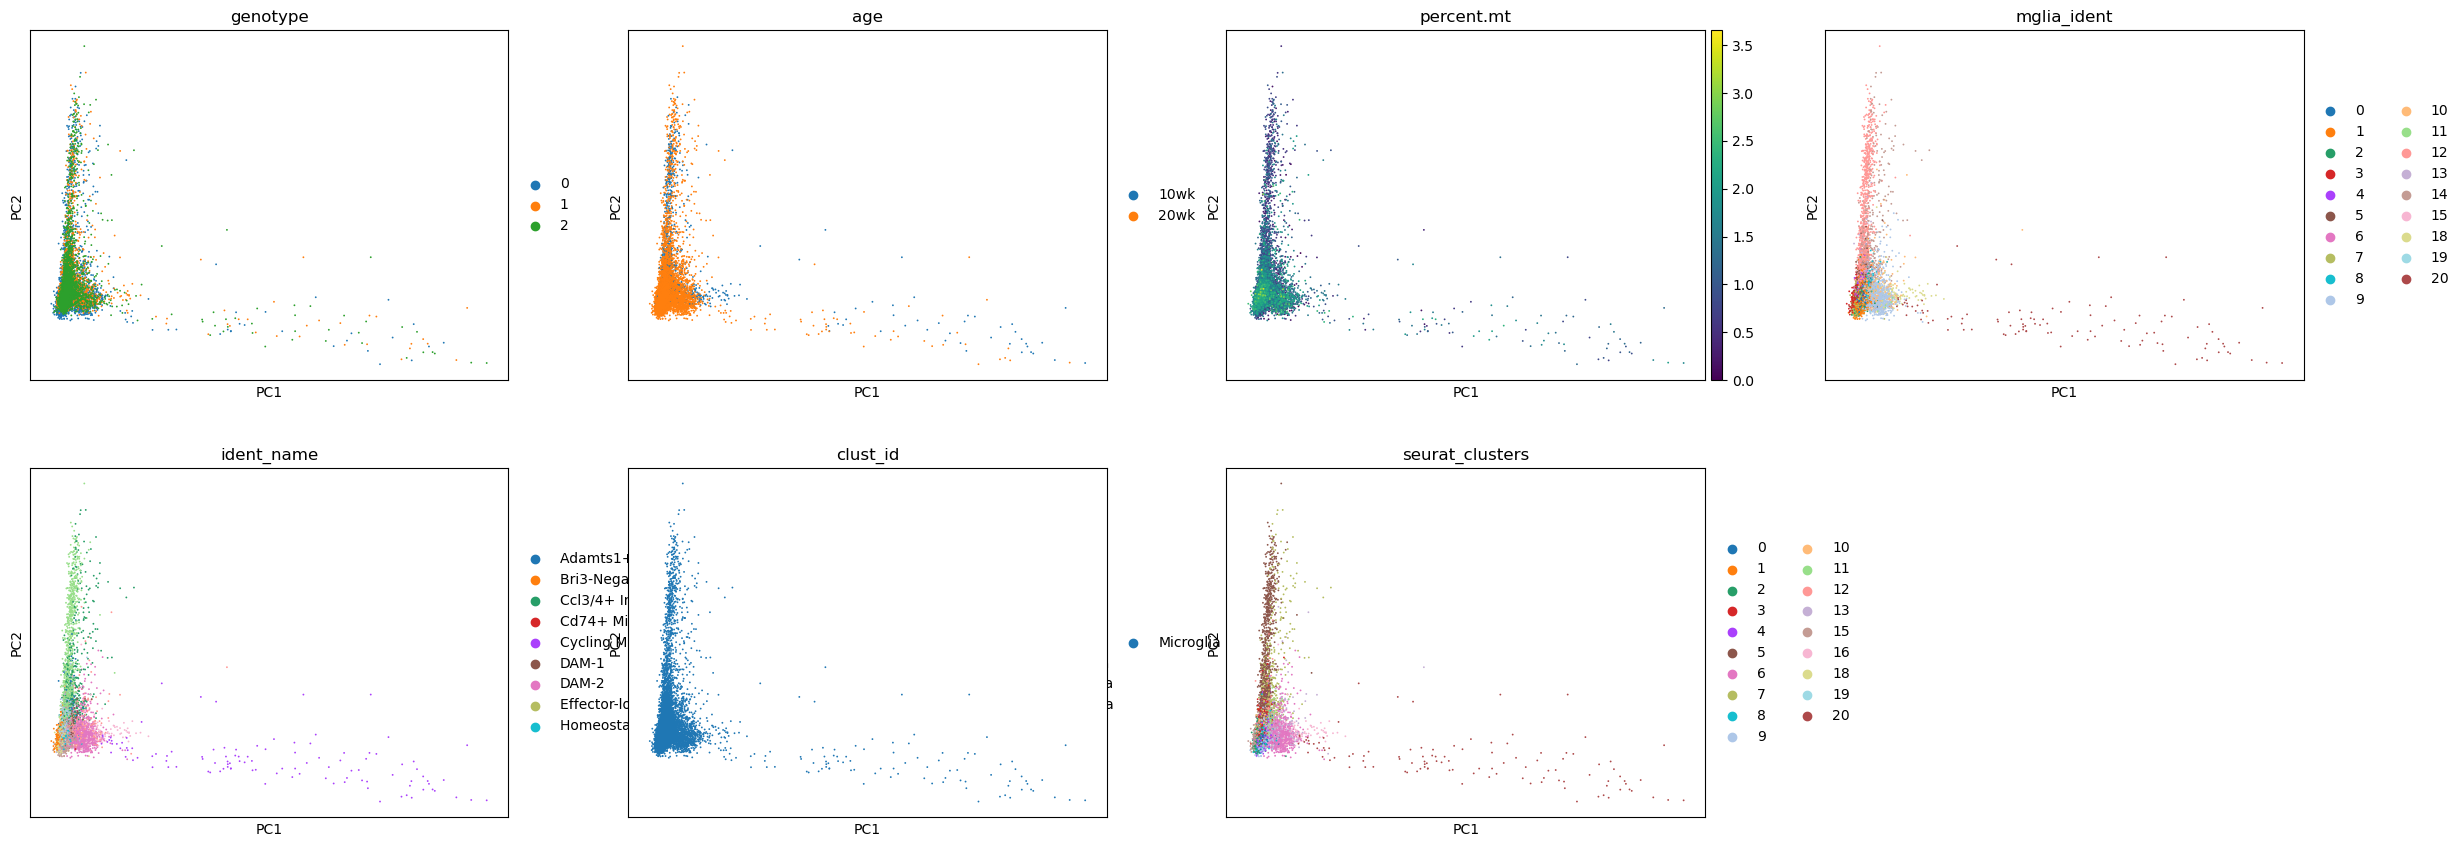

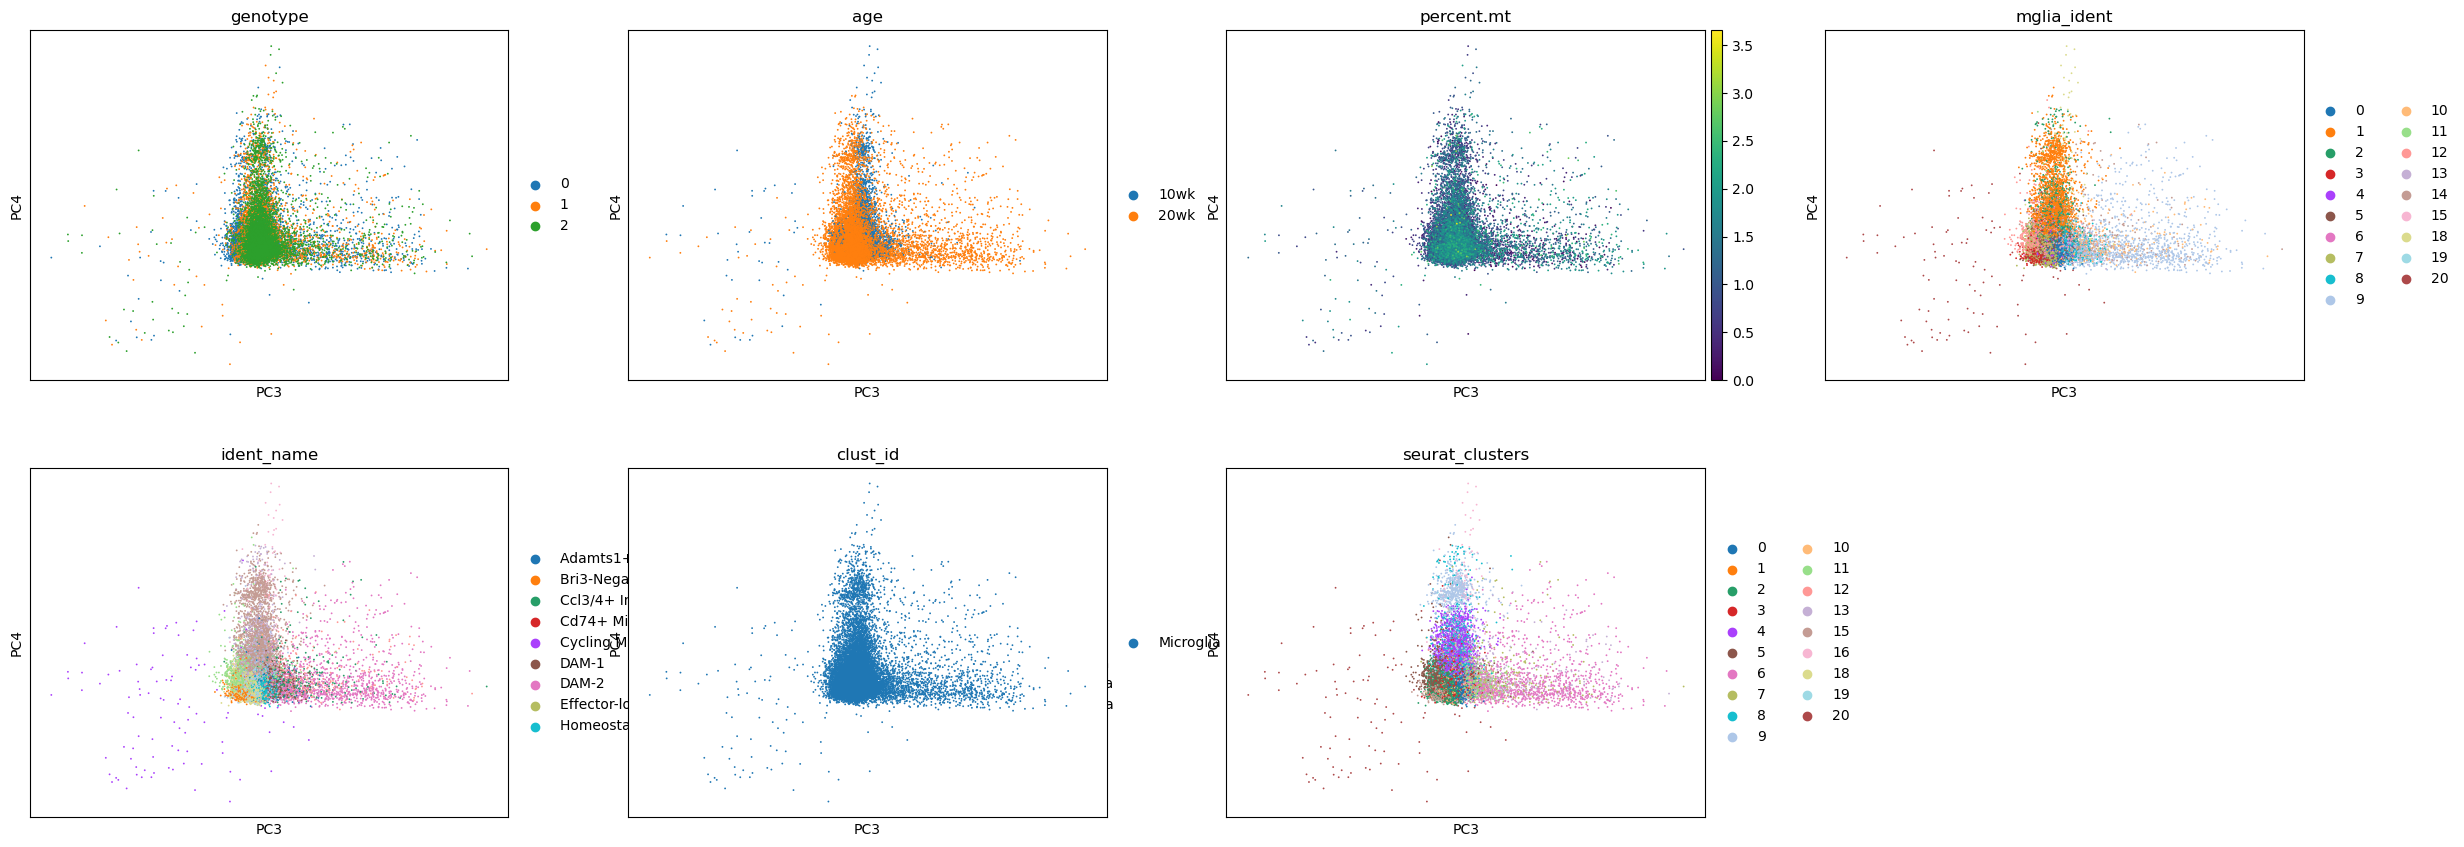

In [14]:
sc.pl.scatter(Madata_recomp, x='nCount_RNA', y='nFeature_RNA', color='percent.mt')
sc.pl.pca(Madata_recomp, color=['genotype','age', 'percent.mt','mglia_ident', 'ident_name', 'clust_id', 'seurat_clusters'])
sc.pl.pca(Madata_recomp, color=['genotype','age', 'percent.mt','mglia_ident', 'ident_name', 'clust_id', 'seurat_clusters'], dimensions=[2,3])

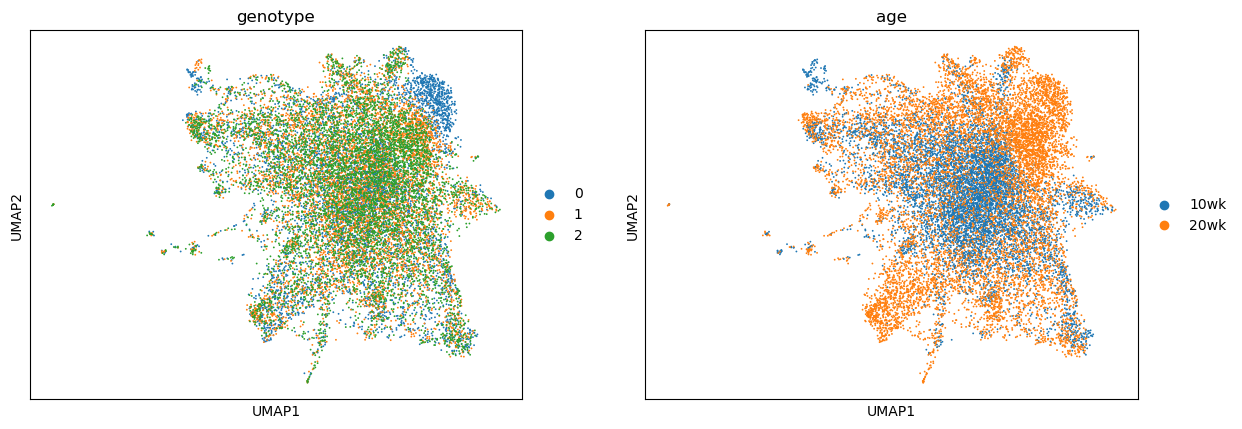

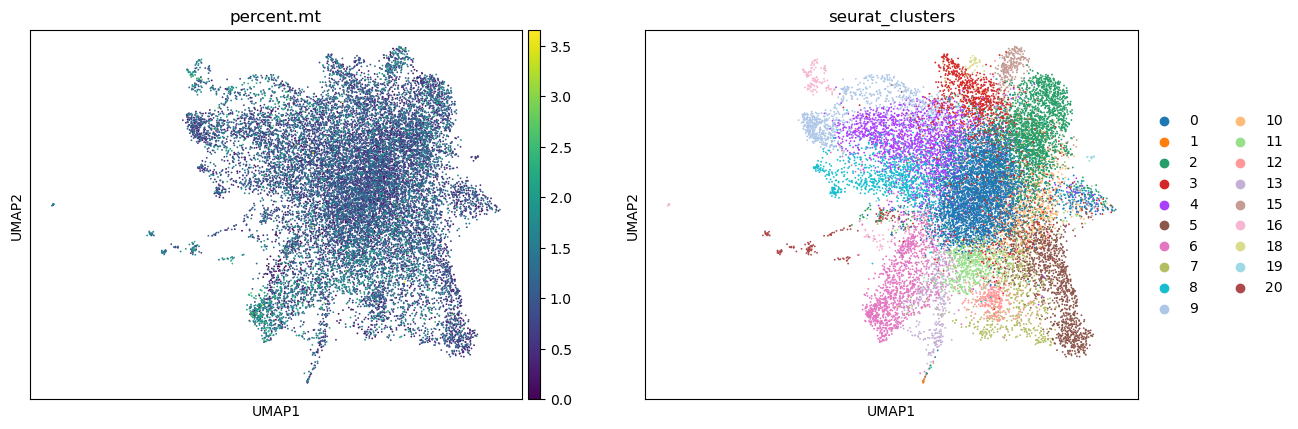

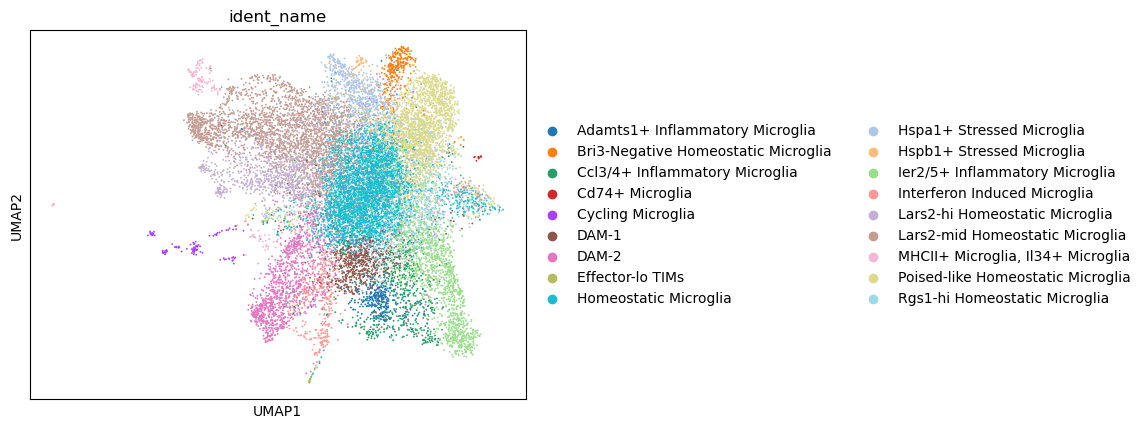

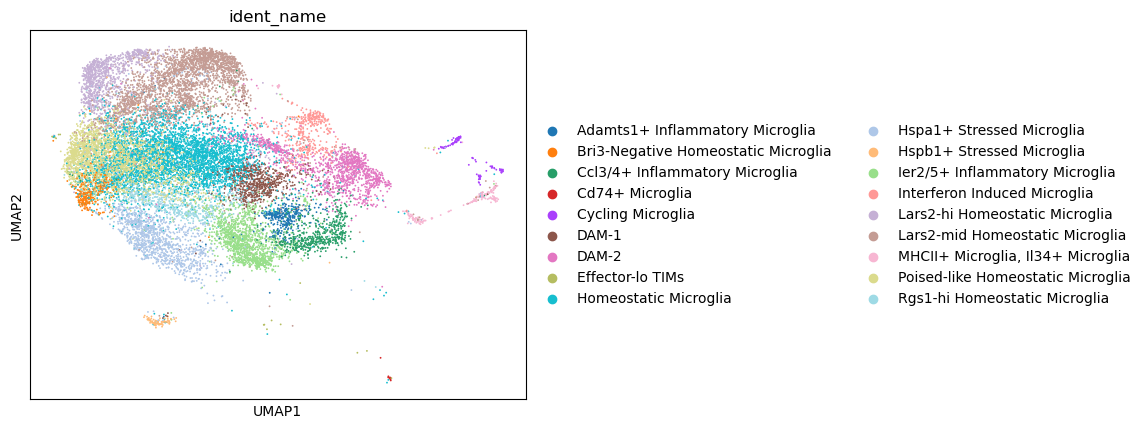

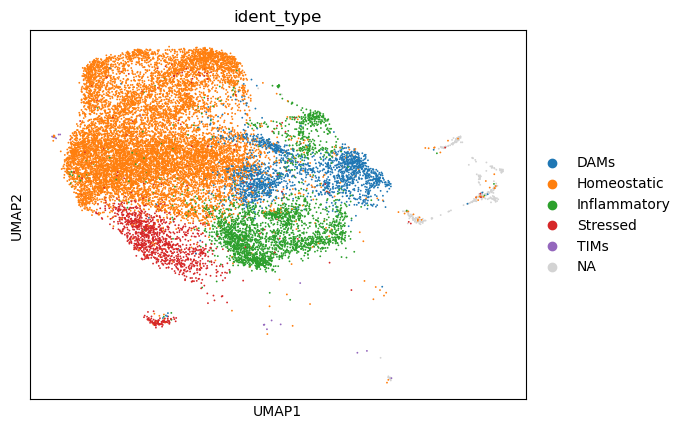

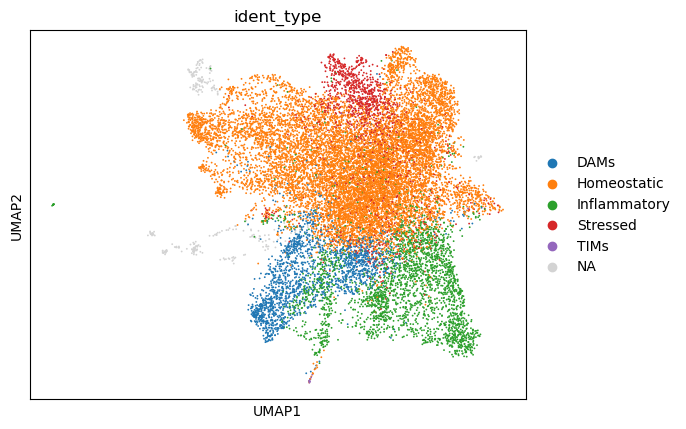

In [15]:
# plot umap 
sc.pl.umap(Madata_recomp, color=['genotype','age'])
sc.pl.umap(Madata_recomp, color=['percent.mt', 'seurat_clusters'])
sc.pl.umap(Madata_recomp, color='ident_name')
sc.pl.umap(Madata, color='ident_name')
sc.pl.umap(Madata, color='ident_type')
sc.pl.umap(Madata_recomp, color='ident_type')

# Integration; Assymetric/Label Transfer=

in the below code we will use PCA and UMAP representations of the millet data and our dataset to project our dataset onto the millet labels. 
using scanpy.tl.ingest. Going to use the uns.neighbours metadata taken directly from the downloaded dataset but may try rerunning neighbours in scanpy to see if there is a meaningful difference from the one ran by the authors in seurat. Will also run on both umap and pca embeddings. 

In [16]:
# Need to ensure to only use the same genes (var_names) in both datasets
var_names = Madata_recomp.var_names.intersection(Adata.var_names)
Madata_recomp = Madata_recomp[:, var_names]
Adata = Adata[:, var_names]

/opt/homebrew/Caskroom/mambaforge/envs/Scanpy_env2_omni/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


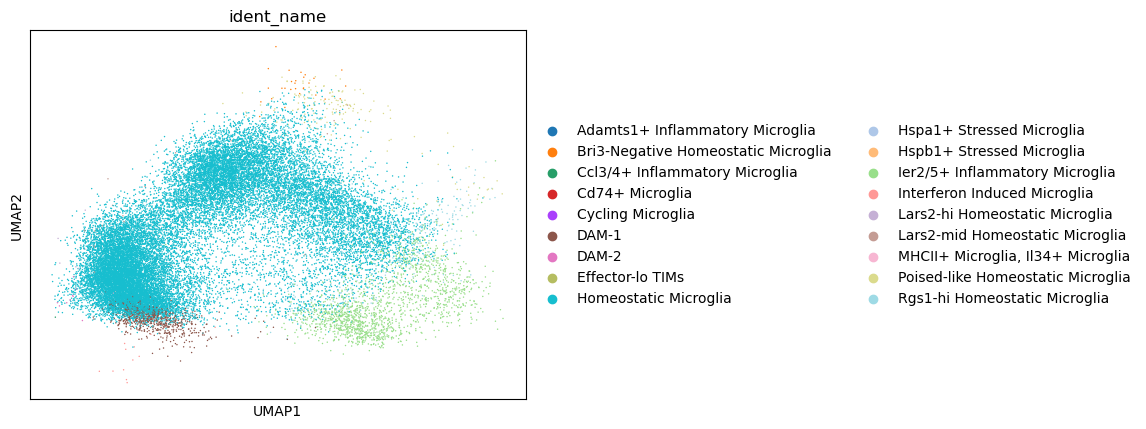

In [22]:

sc.tl.ingest(Adata, Madata_recomp, obs='ident_name', embedding_method='pca')
sc.pl.umap(Adata, color='ident_name')

In [24]:
Adata.obs['ident_name'].value_counts()

ident_name
Homeostatic Microglia                  24786
Ier2/5+ Inflammatory Microglia          1677
DAM-1                                    719
Rgs1-hi Homeostatic Microglia            283
Poised-like Homeostatic Microglia        171
Bri3-Negative Homeostatic Microglia       28
Lars2-mid Homeostatic Microglia           27
Interferon Induced Microglia              13
DAM-2                                      9
Lars2-hi Homeostatic Microglia             7
Ccl3/4+ Inflammatory Microglia             2
MHCII+ Microglia, Il34+ Microglia          0
Adamts1+ Inflammatory Microglia            0
Hspb1+ Stressed Microglia                  0
Effector-lo TIMs                           0
Cycling Microglia                          0
Cd74+ Microglia                            0
Hspa1+ Stressed Microglia                  0
Name: count, dtype: int64

In [ ]:
var_names = Madata_recomp.var_names.intersection(Adata_recomp.var_names)
Madata_recomp = Madata_recomp[:, var_names]
Adata_recomp = Adata_recomp[:, var_names]

/opt/homebrew/Caskroom/mambaforge/envs/Scanpy_env2_omni/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


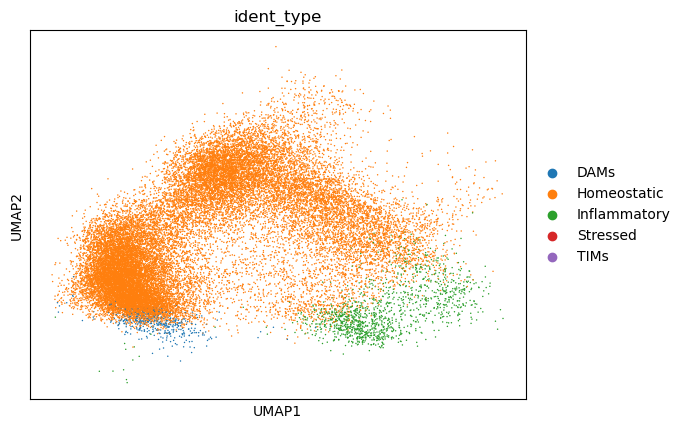

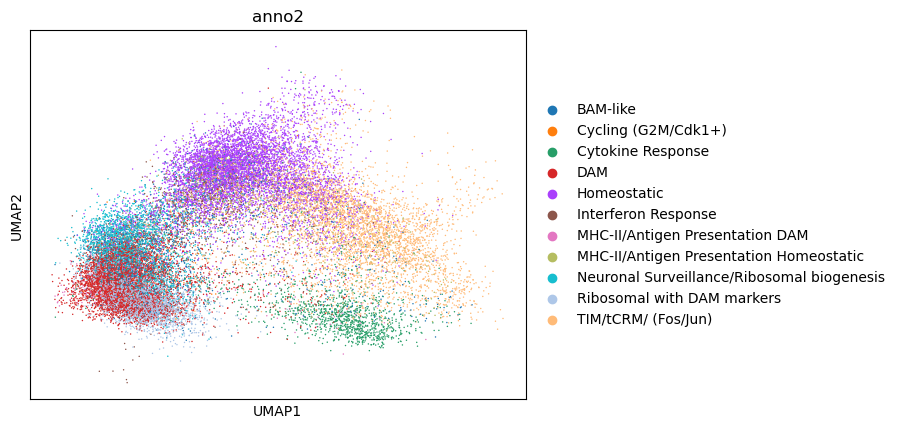

ident_type
Homeostatic     26005
Inflammatory     1287
DAMs              430
Stressed            0
TIMs                0
Name: count, dtype: int64

In [26]:
sc.tl.ingest(Adata, Madata_recomp, obs='ident_type', embedding_method='pca')
sc.pl.umap(Adata, color='ident_type')
sc.pl.umap(Adata, color='anno2')
Adata.obs['ident_type'].value_counts()

# Integration; joint representation by conditional VAE

We will use SCVI to combine and integrate the millet data and our data into the same pca/umap space. 
